# Distributed Training using Tensorflow

### **Distributed Training in TensorFlow**

Distributed training in TensorFlow allows you to scale training across multiple devices and machines, enabling faster training times and the ability to handle larger datasets and models. TensorFlow's `tf.distribute.Strategy` API simplifies this process by providing different strategies for various hardware and configurations.

---

### **What is Distributed Training?**
Distributed training refers to the process of training a machine learning model across multiple devices (GPUs, TPUs, or CPUs) or nodes. This is achieved by:
- Splitting the computation and data across devices.
- Synchronizing updates to the model parameters.

---

### **What is a Distribution Strategy?**
A **distribution strategy** in TensorFlow is a high-level API that abstracts the complexity of distributed training by handling device placement, data sharding, and synchronization. TensorFlow provides several strategies tailored to specific use cases.

---

### **Types of Distribution Strategies**

#### 1. **Default Strategy (`tf.distribute.get_strategy()`)**
- **Description**: The default no-op strategy. It behaves as if there is no distribution strategy and uses only the available device (CPU or single GPU).
- **When to Use**: For simple setups or debugging on a single device.
- **Syntax**:
  ```python
  strategy = tf.distribute.get_strategy()
  ```

---

#### 2. **OneDeviceStrategy**
- **Description**: A strategy that places all computation on a single specified device (e.g., CPU or GPU).
- **When to Use**: For debugging or testing on a specific device.
- **Syntax**:
  ```python
  strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  ```

---

#### 3. **MirroredStrategy**
- **Description**: Replicates the model across multiple GPUs (or CPUs) and synchronizes updates in each step.
- **When to Use**: For synchronous training on multiple GPUs on a single machine.
- **How It Works**: Each GPU gets a copy of the model and processes a different batch of data. Gradients are aggregated, and updates are synchronized.
- **Syntax**:
  ```python
  strategy = tf.distribute.MirroredStrategy()
  ```

---

#### 4. **MultiWorkerMirroredStrategy**
- **Description**: Extends `MirroredStrategy` to multiple workers (machines), synchronizing updates across all devices on all workers.
- **When to Use**: For synchronous training across multiple machines with GPUs.
- **Syntax**:
  ```python
  strategy = tf.distribute.MultiWorkerMirroredStrategy()
  ```

---

#### 5. **TPUStrategy**
- **Description**: A strategy for training on Tensor Processing Units (TPUs). It is optimized for large-scale training with TPUs.
- **When to Use**: For training large models on Google Cloud TPU clusters.
- **Syntax**:
  ```python
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  ```

---

#### 6. **ParameterServerStrategy**
- **Description**: Distributes the model across parameter servers and workers. Parameters are stored on the parameter servers, and workers handle computation.
- **When to Use**: For large-scale asynchronous training across multiple nodes.
- **Syntax**:
  ```python
  strategy = tf.distribute.ParameterServerStrategy()
  ```

---

#### 7. **CentralStorageStrategy**
- **Description**: Places variables on a single device (CPU or a specific GPU) and mirrors computation across multiple devices.
- **When to Use**: When GPU memory is constrained, and variables need to be stored on the CPU or a single GPU.
- **Syntax**:
  ```python
  strategy = tf.distribute.experimental.CentralStorageStrategy()
  ```

---

### **Comparison Table**

| **Strategy**               | **Use Case**                                 | **Devices**           |
|-----------------------------|-----------------------------------------------|-----------------------|
| **Default**                 | Single-device, simple debugging              | CPU/GPU              |
| **OneDeviceStrategy**       | Debugging on a specific device               | CPU or specific GPU  |
| **MirroredStrategy**        | Multi-GPU training on a single machine       | Multiple GPUs        |
| **MultiWorkerMirroredStrategy** | Multi-GPU training across multiple machines | GPUs across nodes    |
| **TPUStrategy**             | Large-scale TPU-based training               | TPUs                 |
| **ParameterServerStrategy** | Large-scale asynchronous training            | Multiple nodes       |
| **CentralStorageStrategy**  | Limited GPU memory, centralized variables    | CPU or single GPU    |

---

### **General Usage**
Regardless of the strategy, the typical workflow involves:
1. Defining the strategy.
2. Placing model creation and compilation inside the strategy’s scope.
3. Training the model.

#### Example Template:

```python
# Define the strategy
strategy = tf.distribute.MirroredStrategy()

# Place model creation and compilation inside the strategy's scope
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(dataset, epochs=10)
```

This sets the foundation for explaining distributed training in TensorFlow and its practical application in your notebook.

## **Applying Distribution Strategies for Fake News Detection**

In this section, we implement distributed training on a real-world NLP dataset for fake news detection. We will explore the training process and performance on single GPU and multi-GPU setups using TensorFlow's distribution strategies. The comparison will focus on training times, speeds, and resource utilization.

---

### **Dataset**
We use a Kaggle dataset containing labeled news articles for fake news detection. The dataset is preprocessed to:
- Tokenize text using TensorFlow's `Tokenizer`.
- Convert labels into binary format.
- Split into training, validation, and test sets.

---

### **Hardware Setup**

#### **Single GPU (Local Machine)**
- **Device**: Laptop
- **CPU**: Intel Core i7-13650H
- **GPU**: NVIDIA RTX 3070
- **Strategy**: `tf.distribute.OneDeviceStrategy`

#### **Multi-GPU (Kaggle Environment)**
- **Device**: Kaggle Notebook
- **Accelerator**: 2 NVIDIA Tesla T4 GPUs
- **Strategy**: `tf.distribute.MirroredStrategy`

#### **TPU (Kaggle Environment)**
- **Device**: Kaggle Notebook
- **Accelerator**: TPU VM V3-8
- **Strategy**: `strategy = tf.distribute.TPUStrategy(resolver)`
---

### **Steps**
1. Implement a model for fake news detection using:
   - LSTM
   - Transformer
2. Train on:
   - Single GPU (using `OneDeviceStrategy`).
   - Multiple GPUs (using `MirroredStrategy`).
   - TPU (using `TPUStrategy`).
3. Compare the training time and performance.

---


# Fake News Detection

[Fake News Classification Dataset Link](https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification)<br>
In this project, we aim to build a model that can detect fake news. We will use a dataset containing news articles labeled as fake or real. The focus here is on how distributed training is utilized, as this approach allows for scaling the training process across multiple devices. The results could have improved with extended training time, but the primary emphasis is on the use of distributed training techniques. .<br>

## Importing required libraries

In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf 

from sklearn.model_selection import train_test_split


## Data Loading and Preprocessing

We will load the datasets and combine the `title` and `text` columns into a single `content` column. We will also drop unnecessary columns.

In [ ]:
train_data = pd.read_csv('/kaggle/input/fake-news-classification/train (2).csv',sep=';')
train_data.head(5)

In [ ]:

# Assuming train_data is already loaded as a DataFrame
first_row = train_data.iloc[0]
pd.set_option('display.max_colwidth', None)
print(first_row)

In [ ]:
val_data = pd.read_csv('/kaggle/input/fake-news-classification/evaluation.csv',sep=';')
val_data.head(1)

In [ ]:
test_data = pd.read_csv('/kaggle/input/fake-news-classification/test (1).csv',sep=';')
test_data.head(1)

## Preparing data for Model

#### Tokenization and Padding

We will use the TensorFlow tokenizer to convert the text data into sequences of integers. We will then pad the sequences to ensure they have a uniform length.

In [ ]:

# Combine title and text columns
train_data['content'] = train_data['title'] + " " + train_data['text']
test_data['content'] = test_data['title'] + " " + test_data['text']
val_data['content'] = val_data['title'] + " " + val_data['text']

# Drop unnecessary columns
train_data = train_data.drop(columns=['Unnamed: 0', 'title', 'text'])
test_data = test_data.drop(columns=['Unnamed: 0', 'title', 'text'])
val_data = val_data.drop(columns=['Unnamed: 0', 'title', 'text'])


In [ ]:

# Combine all data for tokenizer training
combined_data = pd.concat([train_data, test_data,val_data])

# Tokenization and padding
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_data['content'])


In [ ]:

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['content'])
test_sequences = tokenizer.texts_to_sequences(test_data['content'])
val_sequences = tokenizer.texts_to_sequences(val_data['content'])


# Determine the maximum length of the sequences
max_length = max(len(seq) for seq in train_sequences + test_sequences + val_sequences)

# Pad sequences to ensure uniform length
train_x = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_x = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length, padding='post')
val_x = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=max_length, padding='post')

# Extract labels
train_y = train_data['label'].values
test_y = test_data['label'].values
val_y = val_data['label'].values


## Creating a NLP model using Bidirectional LSTMs

### Model Architecture

We have built a sequential model using TensorFlow's Keras API. The model consists of the following layers:

1. **Embedding Layer**:
    - **Purpose**: Converts the input sequences of integers into dense vectors of fixed size.
    - **Parameters**:
        - `input_dim=5000`: The size of the vocabulary (number of unique words).
        - `output_dim=128`: The dimension of the dense embedding vectors.
        - `input_length=max_length`: The length of the input sequences.

2. **Bidirectional LSTM Layer (1st)**:
    - **Purpose**: Captures dependencies in the input sequences in both forward and backward directions.
    - **Parameters**:
        - `units=64`: The number of LSTM units in each direction.
        - `return_sequences=True`: Ensures that the output is a sequence of the same length as the input.

3. **Bidirectional LSTM Layer (2nd)**:
    - **Purpose**: Further captures dependencies in the input sequences in both forward and backward directions.
    - **Parameters**:
        - `units=32`: The number of LSTM units in each direction.
        - `return_sequences=False`: Ensures that the output is a single vector (the last output of the LSTM).

4. **Dense Layer**:
    - **Purpose**: Adds a fully connected layer to learn complex representations.
    - **Parameters**:
        - `units=64`: The number of neurons in the dense layer.
        - `activation='relu'`: The activation function used to introduce non-linearity.

5. **Dropout Layer**:
    - **Purpose**: Prevents overfitting by randomly setting a fraction of input units to 0 at each update during training.
    - **Parameters**:
        - `rate=0.5`: The fraction of input units to drop.

6. **Output Layer**:
    - **Purpose**: Produces the final output of the model.
    - **Parameters**:
        - `units=1`: The number of neurons in the output layer (since this is a binary classification problem).
        - `activation='sigmoid'`: The activation function used to produce a probability score between 0 and 1.


The model starts with an embedding layer to convert the input sequences into dense vectors. It then uses two bidirectional LSTM layers to capture dependencies in the sequences in both directions. A dense layer with ReLU activation is added to learn complex representations, followed by a dropout layer to prevent overfitting. Finally, a sigmoid-activated dense layer is used to produce the output, which is a probability score indicating whether the news is fake or real.

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))


In [ ]:
# Display the model summary
model.summary()

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f'Test Accuracy: {test_accuracy}')

# Predict and calculate accuracy
predictions = (model.predict(test_x) > 0.5).astype("int32")
accuracy = accuracy_score(test_y, predictions)
print(f'Accuracy: {accuracy}')

## Now lets use distributed training and see the difference

In [ ]:
import tensorflow as tf

# Verify GPU access
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
else:
    print("No GPUs available")

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Verify GPU access
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
else:
    print("No GPUs available")

# Set up distributed strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_x, train_y, epochs=5, batch_size=256, validation_data=(val_x, val_y))

In [ ]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
predictions = model.predict(test_x)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_y, predictions)
print(f"Test Accuracy (calculated): {accuracy}")

### **Comparison of Single GPU vs Multi-GPU Performance (LSTMs)**

Below is a concise comparison of the training performance for Fake News Detection using TensorFlow on two setups: a **single GPU (RTX 3070)** and **multi-GPU (2x Tesla T4)**. The comparison highlights training times, accuracy, and efficiency.

---

### **Key Observations**

| **Metric**                  | **Single GPU (RTX 3070)**                   | **Multi-GPU (2x Tesla T4)**              | **Remarks**                                    |
|-----------------------------|---------------------------------------------|------------------------------------------|-----------------------------------------------|
| **Epoch Duration**          | ~500 seconds                               | ~113 seconds                             | Multi-GPU training is ~4.4x faster per epoch. |
| **Training Accuracy**       | **99.77%** after 5 epochs                  | **99.31%** after 5 epochs                | Comparable training accuracy.                 |
| **Validation Accuracy**     | 98.40%                                     | 98.40%                                   | Both setups perform equally on validation.    |
| **Test Accuracy**           | **99.96%**                                 | **98.55%**                               | Single GPU achieved marginally better test accuracy. |
| **Test Loss**               | 0.0731                                     | 0.0494                                   | Multi-GPU slightly outperformed in loss.      |
| **Training Time (Total)**   | ~41 minutes (5 epochs)                     | ~9 minutes (5 epochs)                    | Multi-GPU setup significantly reduces total training time. |

---

### **Insights**
1. **Speed**: Multi-GPU training is significantly faster, reducing the epoch duration by ~78%. This efficiency is crucial for larger datasets and models.
2. **Accuracy**: Both setups achieved high accuracy, with the single GPU slightly outperforming on the test set. This difference may be due to better hyperparameter tuning for the single GPU run.
3. **Efficiency**: While both strategies deliver strong results, multi-GPU training is highly advantageous for saving time without compromising accuracy.

---

### **Conclusion**
- **When to Use Single GPU**: Ideal for smaller-scale tasks or debugging, especially on personal machines.
- **When to Use Multi-GPU**: Perfect for large-scale training, enabling rapid iteration and efficient use of resources.

Multi-GPU distributed training demonstrates a clear advantage in speed, making it a preferred choice for scaling up machine learning workflows.

## Transformer Model

#### First we shall look at single GPU performance ,the model used here is very simplified compared to that used in multiGPU architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout, Input, Embedding, GlobalAveragePooling1D

class SimpleTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(SimpleTransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def simple_transformer_model(input_shape, vocab_size):
    inputs = Input(shape=input_shape)
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=32)(inputs)  
    transformer_block = SimpleTransformerBlock(embed_dim=32, num_heads=1, ff_dim=32)  
    x = GlobalAveragePooling1D()(x)
    x = Dense(8, activation='relu')(x)  
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build the simpler model
model = simple_transformer_model((max_length,), 5000)

I0000 00:00:1735152983.724794   14998 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735152983.755043   14998 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735152983.755088   14998 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735152983.758691   14998 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735152983.758767   14998 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6961)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 6961, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_transformer_block        │ (None, 6961, 32)       │         6,464 │
│ (SimpleTransformerBlock)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,737 (651.32 KB)

 Trainable params: 166,737 (651.32 KB)

 Non-trainable params: 0 (0.00 B)

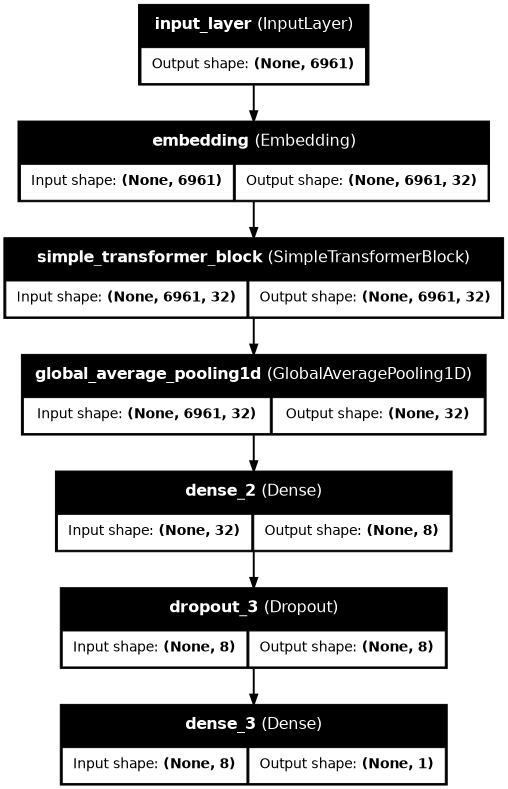

In [ ]:
# Plot the model
from tensorflow.keras.utils import plot_model

# Plot the model with reduced image size
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=70)

In [ ]:

# Train the model
history = model.fit(train_x, train_y, epochs=10, batch_size=8, validation_data=(val_x, val_y))

Epoch 1/50


I0000 00:00:1735153007.843861   15869 service.cc:146] XLA service 0x7f5580007660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735153007.843902   15869 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-25 18:56:47.919445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-25 18:56:48.172476: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90400
2024-12-25 18:56:49.207773: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 312 bytes spill stores, 312 bytes spill loads

2024-12-25 18:56:49.311525: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memo

3044/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5386 - loss: 0.6928

2024-12-25 19:01:49.756712: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 4 bytes spill stores, 4 bytes spill loads

2024-12-25 19:01:50.321547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 16 bytes spill stores, 16 bytes spill loads

2024-12-25 19:01:50.368133: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 332 bytes spill stores, 336 bytes spill loads

2024-12-25 19:01:51.558582: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 4 bytes spill stores, 4 bytes spill loads

2024-12-25 19:01:51.747181: I external/local_xla/xla/stream_executor/c

3045/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5386 - loss: 0.6928

2024-12-25 19:02:45.613382: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 588 bytes spill stores, 588 bytes spill loads

2024-12-25 19:02:45.677683: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 312 bytes spill stores, 312 bytes spill loads



3045/3045 ━━━━━━━━━━━━━━━━━━━━ 361s 115ms/step - accuracy: 0.5386 - loss: 0.6928 - val_accuracy: 0.5316 - val_loss: 0.6912
Epoch 2/50
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 332s 109ms/step - accuracy: 0.7403 - loss: 0.4875 - val_accuracy: 0.9662 - val_loss: 0.1330
Epoch 3/50
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 371s 122ms/step - accuracy: 0.9380 - loss: 0.1992 - val_accuracy: 0.9735 - val_loss: 0.0901
Epoch 4/50
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 375s 123ms/step - accuracy: 0.9467 - loss: 0.1439 - val_accuracy: 0.9754 - val_loss: 0.0820
Epoch 5/50
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 370s 121ms/step - accuracy: 0.9470 - loss: 0.1342 - val_accuracy: 0.8348 - val_loss: 0.5187
Epoch 6/50
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 406s 134ms/step - accuracy: 0.7850 - loss: 0.4244 - val_accuracy: 0.9476 - val_loss: 0.1185
Epoch 7/50
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 402s 132ms/step - accuracy: 0.9617 - loss: 0.1333 - val_accuracy: 0.9724 - val_loss: 0.1033
Epoch 8/50
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 396s 130ms/step - accuracy: 0.9

#### Now we shall look at MULTI GPU Performance, Here a bigger architecture is used

In [ ]:
import gc
import tensorflow as tf
from numba import cuda

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Run garbage collection
gc.collect()

# Clear GPU memory
cuda.select_device(0)
cuda.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Verify GPU access
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
else:
    print("No GPUs available")

class SimpleTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(SimpleTransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def simple_transformer_model(input_shape, vocab_size):
    inputs = Input(shape=input_shape)
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=128)(inputs) 
    transformer_block = SimpleTransformerBlock(embed_dim=128, num_heads=2, ff_dim=128)
    x = transformer_block(embedding_layer, training=True)
    x = GlobalAveragePooling1D()(x)
    x = Dense(8, activation='relu')(x)  # Reduced number of units
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Set up distributed strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Build the simpler model
    model = simple_transformer_model((max_length,), 5000)

    # Compile the model with a lower learning rate and gradient clipping
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Define the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath='simple_transformer_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )


In [ ]:
# Display the model summary
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=70)

In [ ]:
# Train the model with the callback
history = model.fit(train_x, train_y, epochs=15, batch_size=16, validation_data=(val_x, val_y), callbacks=[checkpoint_callback])


In [ ]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
predictions = model.predict(test_x)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predictions)
print(f"Test Accuracy (calculated): {accuracy}")

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Comparision between the results single gpu vs multiple gpu speed ,time:

#### Single GPU results
A simple transformer architecture is used on Laptop due to hardware constraints<br>
<img src = 'laptoptransformerconfig.png' width=400><br>
<img src='sigleGPUresulttransformer.png' ><br>
<img src = 'Transformer_local_GPU_utilization.png' width=300>

#### Multi GPU results
<img src='multigputransformerconfig.png' width=400><br>
**Time Taken for each epoch : 1500s** <br><br>
(since model is big and learning rate is lowered on 5 epochs the accuracy was around 60% could be improved on further training)<br>
<img src = 'transformer_keggle_multigpu.png' width=200>

# Using TPU on Kaggle for Model Training

To leverage the power of TPUs on Kaggle for training your model, follow these steps:

1. **Set Up TPU**:
   - Connect to the TPU using `TPUClusterResolver`.
   - Initialize the TPU system.

2. **Define and Compile the Model within TPU Strategy Scope**:
   - Use `tf.distribute.TPUStrategy` to distribute the training across TPU cores.
   - Define and compile your model within the TPU strategy scope.

3. **Train the Model**:
   - Adjust the batch size to utilize the TPU effectively by multiplying it with `strategy.num_replicas_in_sync`.
   - Use the `ModelCheckpoint` callback to save the best model based on validation loss.

Here is the complete code to set up and train a simplified transformer model on a TPU:



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set up TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

class SimpleTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(SimpleTransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def simple_transformer_model(input_shape, vocab_size):
    inputs = Input(shape=input_shape)
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=32)(inputs)  # Reduced output dimension
    transformer_block = SimpleTransformerBlock(embed_dim=32, num_heads=1, ff_dim=32)  # Reduced number of heads and ff_dim
    x = transformer_block(embedding_layer, training=True)
    x = GlobalAveragePooling1D()(x)
    x = Dense(8, activation='relu')(x)  # Reduced number of units
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

with strategy.scope():
    # Build the simpler model
    model = simple_transformer_model((max_length,), 5000)

    # Compile the model with a lower learning rate and gradient clipping
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Define the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath='simple_transformer_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )


In [ ]:
# Train the model with the callback
history = model.fit(train_x, train_y, epochs=3, batch_size=64 * strategy.num_replicas_in_sync, validation_data=(val_x, val_y), callbacks=[checkpoint_callback])

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
predictions = model.predict(test_x)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predictions)
print(f"Test Accuracy (calculated): {accuracy}")

### **Why I used my Laptop for Single GPU Training?**

Training models on a laptop with a single GPU is often a practical and convenient choice. Here’s why:  

1. **No Internet Dependency**: You can train models offline without relying on cloud infrastructure or internet connectivity.  
2. **Local GPU Power**: Many modern laptops are equipped with powerful GPUs capable of handling demanding machine learning tasks efficiently.  
3. **Cost-Effective**: Training locally eliminates the cost of renting cloud GPUs or multi-GPU setups for smaller projects.  
4. **Customization**: You have full control over the environment, making it easier to experiment with configurations and dependencies.  
5. **Convenience**: Having everything on a single machine allows for faster debugging and development cycles.
6.  **Avoid Time Out Issues**: One of the biggest irritations of cloud platforms like Kaggle is receiving the dreaded “Are you still there?” message after leaving a model to train overnight. With local training, this frustration is entirely avoided!

#### **Setting Up Your Local Environment**
To make setting up a machine learning environment easy, I recommend using **Lambda Stack**. It simplifies the process by installing all the necessary components like TensorFlow, PyTorch, CUDA, and drivers in one go.  

Visit [Lambda Stack](https://lambdalabs.com/lambda-stack-deep-learning-software) and follow the commands provided there. Once set up, you’re ready to enjoy training on your local machine with minimal effort!